## Extract Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/training data/Training and Validation Data_2023_T1_COMP3010.zip' -d training

In [ ]:
!unzip '/content/drive/MyDrive/training data/Testing Data_Dubai_2023.zip' -d test

In [11]:
#!rmdir '/content/training/Data/coral image classification/train/.ipynb_checkpoints'

## Load Libraries

In [12]:
## Python Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import numpy as np

## Neural Network
import torch as tr
import torchvision.datasets as datasets
from torchvision import models
import torchvision.transforms as trnsform
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from pylab import *

In [13]:
import warnings
warnings.filterwarnings("ignore")

## Check Tourch Version

In [14]:
print("Using torch", tr.__version__)

Using torch 1.13.1+cu116


## Checking Cuda Support (GPU)

In [15]:
print(tr.cuda.device_count())
print(tr.cuda.get_device_name(0))

1
Tesla T4


#Assign cuda GPU located at location '0' to a variable


In [16]:
cuda0 = tr.device('cuda:0')
cuda0

device(type='cuda', index=0)

## Seed Settings

In [17]:
tr.cuda.manual_seed(1)
tr.backends.cudnn.deterministic = True
tr.backends.cudnn.benchmark = False

## Load Dataset

In [18]:
# ToTenssor, Convert Image into Pixel of Range [0,255] and images are normalized.
transform = trnsform.Compose([trnsform.Resize(255),trnsform.CenterCrop(224),trnsform.ToTensor()])

traindata = datasets.ImageFolder(root='/content/training/Data/coral image classification/train',transform=transform)
# Val Data
valdata = datasets.ImageFolder(root='/content/training/Data/coral image classification/val',transform=transform)
## Test Data
testdata = datasets.ImageFolder(root='/content/test/Testing Data_2023/Testing Data_withLabels/CoralImageClassification',transform=transform)

## Train Data

* Train Data has 1117 Datapoints

In [19]:
traindata

Dataset ImageFolder
    Number of datapoints: 1117
    Root location: /content/training/Data/coral image classification/train
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

## Val Data

* Val Data has 400 Datapoints

In [20]:
valdata

Dataset ImageFolder
    Number of datapoints: 400
    Root location: /content/training/Data/coral image classification/val
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

## Test Data

* Test Data has 400 Datapoints

In [21]:
testdata

Dataset ImageFolder
    Number of datapoints: 400
    Root location: /content/test/Testing Data_2023/Testing Data_withLabels/CoralImageClassification
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

## Classes of Dataset

In [22]:
classes=traindata.classes
classes

['Coral Images', 'Non-Coral Images']

## Loading Data From Images into Varaibles

In [23]:
X_trian = tr.utils.data.DataLoader(traindata, batch_size=32, shuffle=True)
X_test = tr.utils.data.DataLoader(testdata, batch_size=32, shuffle=True)
X_val = tr.utils.data.DataLoader(valdata, batch_size=32, shuffle=True)

## Printing Batch and Labels size

In [24]:
batch, labels = next(iter(X_trian))

In [25]:
print("Batch size", batch.size()[0])
print("Image size", batch.size()[2],"x",batch.size()[3])
print("Image Channel", batch.size()[1])
print("Label size,", labels.size())

Batch size 32
Image size 224 x 224
Image Channel 3
Label size, torch.Size([32])


## Ploting Images

In [26]:
def functionlabel(label):
  if label == 1:
    return 'Coral Image'
  else:
    return 'Non-Coral Image'

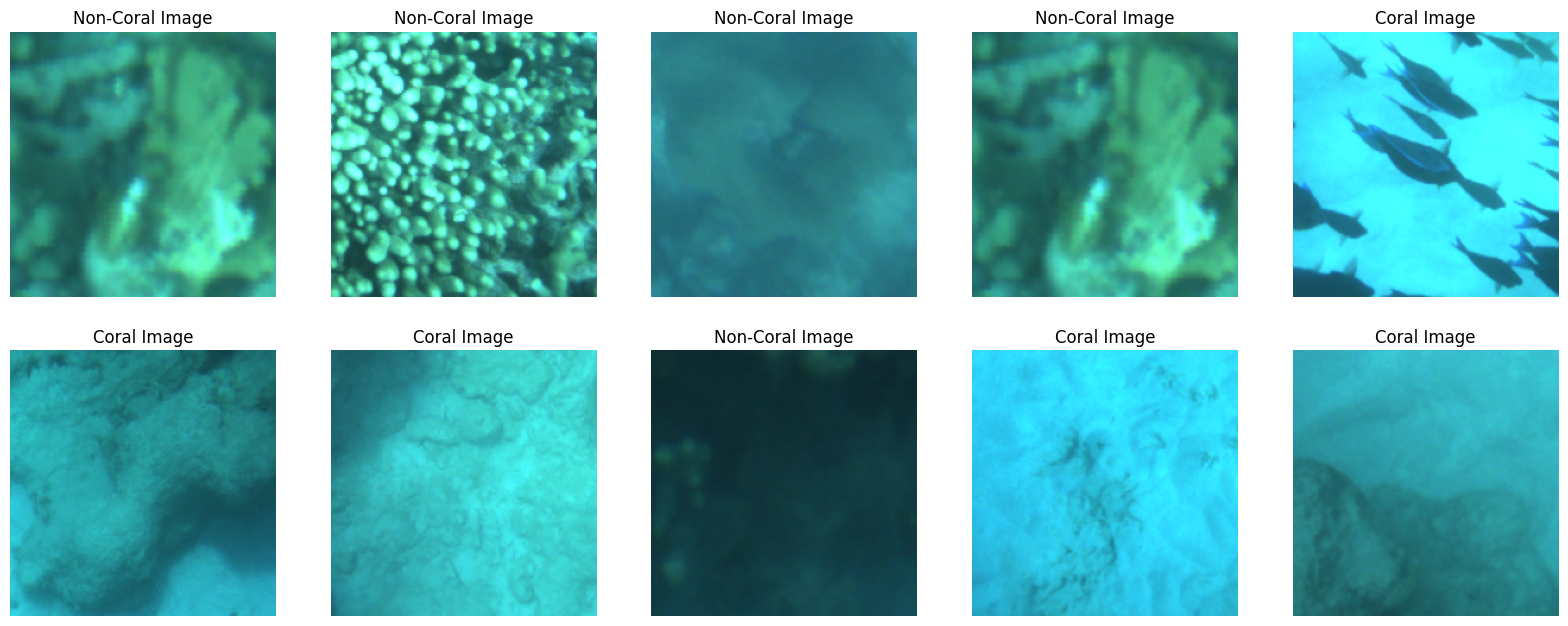

In [27]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(batch),10))) : 
    plt.subplot(5,5,n+1)
    plt.imshow(batch[i].T)
    plt.title(functionlabel(labels[i]))
    plt.axis('off')     
plt.show()

## Labels

In [28]:
y_train = np.array([y for x, y in iter(traindata)])
y_test = np.array([y for x, y in iter(testdata)])
y_val = np.array([y for x, y in iter(valdata)])

## Training Count

In [29]:
f, ax = plt.subplots(figsize = (6,4))
plt.title('Total Training Count of Images')
sns.countplot(x = y_train, palette = 'magma')
plt.show()

## Test Count

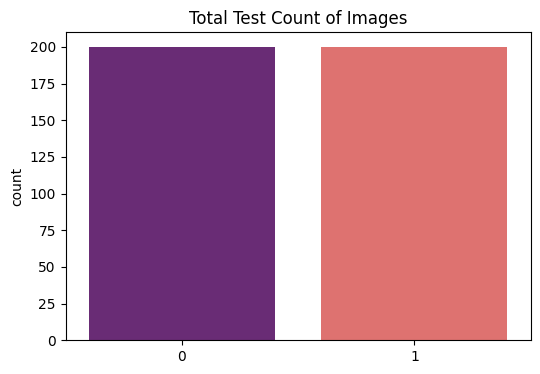

In [30]:
f, ax = plt.subplots(figsize = (6,4))
plt.title('Total Test Count of Images')
sns.countplot(x = y_test, palette = 'magma')
plt.show()

## Creating ResNet18

In [31]:
res18 = models.resnet18(pretrained=True).to(cuda0)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

## Model

In [32]:
res18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Closing Final Layer

In [33]:
for param in res18.parameters():
    param.requires_grad = False

## Building Final Output Layer

In [34]:
res18.fc = nn.Sequential(
               nn.Linear(512, 128),
               nn.Dropout(0.2),
               nn.Linear(128, 64),
               nn.ReLU(inplace=True),
               nn.Linear(64, 2)).to(cuda0)

## Model Compiler

In [35]:
number_epochs = 20
loss = nn.CrossEntropyLoss()
opti = optim.Adam(res18.fc.parameters())
steprs = len(X_trian)

## Train Model

In [36]:
loader =  {'training': X_trian,'val': X_val}
imagesize = {'training':len(X_trian.dataset),'val':len(X_val.dataset)}

In [37]:
for epoch in range(20):
  print('Epoch {}/{}'.format(epoch+1, 20))
  print('-' * 10)
  
  for method in ['training', 'val']:
    if method == 'training':
      res18.train()
    else:
      res18.eval()

    current_loss = 0.0
    correct_accuracy = 0

    for inputs, labels in loader[method]:
      inputs = inputs.to(cuda0)
      labels = labels.to(cuda0)

      outputs = res18(inputs)
      lossC = loss(outputs, labels)

      if method == 'training':
        opti.zero_grad()
        lossC.backward()
        opti.step()
        
      _, preds = tr.max(outputs, 1)
      current_loss += lossC.item() * inputs.size(0)
      correct_accuracy += tr.sum(preds == labels.data)

    loss_epoch = current_loss / imagesize[method]
    acc_epoch = correct_accuracy.double() / imagesize[method]    

    print('{} loss: {:.4f}, acc: {:.4f}'.format(method,loss_epoch,acc_epoch))   

Epoch 1/20
----------
training loss: 0.3129, acc: 0.8693
val loss: 0.1463, acc: 0.9350
Epoch 2/20
----------
training loss: 0.1116, acc: 0.9606
val loss: 0.0313, acc: 0.9925
Epoch 3/20
----------
training loss: 0.1546, acc: 0.9472
val loss: 0.0625, acc: 0.9900
Epoch 4/20
----------
training loss: 0.1351, acc: 0.9526
val loss: 0.0274, acc: 0.9925
Epoch 5/20
----------
training loss: 0.0968, acc: 0.9660
val loss: 0.0275, acc: 0.9900
Epoch 6/20
----------
training loss: 0.0924, acc: 0.9651
val loss: 0.0238, acc: 0.9925
Epoch 7/20
----------
training loss: 0.0842, acc: 0.9660
val loss: 0.0331, acc: 0.9925
Epoch 8/20
----------
training loss: 0.0832, acc: 0.9714
val loss: 0.0656, acc: 0.9775
Epoch 9/20
----------
training loss: 0.0822, acc: 0.9740
val loss: 0.0162, acc: 0.9950
Epoch 10/20
----------
training loss: 0.0536, acc: 0.9848
val loss: 0.0622, acc: 0.9800
Epoch 11/20
----------
training loss: 0.1423, acc: 0.9472
val loss: 0.0628, acc: 0.9750
Epoch 12/20
----------
training loss: 0.0

## Prediction on Test Data

In [38]:
pred = []
actual_label = []
## Test Data evaluation
res18.eval()
## Loop thorugh each test batch
for batch_id, (inputtest, targetlabel) in enumerate(X_test): 
  ## Using Cuda device
  inputtest, targetlabel = inputtest.cuda(), targetlabel.cuda()
  ## Predication
  ps = res18(inputtest)
  prediction = tr.argmax(ps, 1)
  ## Model Appending
  pred.append(prediction.cpu().tolist())
  actual_label.append(targetlabel.cpu().tolist())

## Storing each batch list into single list

In [39]:
## Prediction Labels
preds = []
for x in pred:
  for y in x:
    preds.append(y)

In [40]:
# Target Labels
actual_labels = []
for x in actual_label:
  for y in x:
    actual_labels.append(y)

## Evaluation Metric for Test Data



In [41]:
# Creating the confusion matrix:
e_cm = confusion_matrix(actual_labels, preds)
# Visualization:
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(e_cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='.0f', ax=ax, cmap='coolwarm_r')
plt.title('ResNet18 Classification Confusion Matrix')
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

In [43]:
print(classification_report(actual_labels, preds))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       200
           1       1.00      0.98      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400

